<a href="https://colab.research.google.com/github/ydesquitado/APM1220/blob/main/DESQUITADO_APM1220_FA5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [182]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from pingouin import box_m
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

path = "/content/employee_attrition_train.csv"

data = pd.read_csv(path)

data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,50.0,No,Travel_Rarely,1126.0,Research & Development,1.0,2,Medical,1,997,...,3,80,1,32,1,2,5,4,1,3
1,36.0,No,Travel_Rarely,216.0,Research & Development,6.0,2,Medical,1,178,...,4,80,2,7,0,3,3,2,0,1
2,21.0,Yes,Travel_Rarely,337.0,Sales,7.0,1,Marketing,1,1780,...,2,80,0,1,3,3,1,0,1,0
3,50.0,No,Travel_Frequently,1246.0,Human Resources,NaN,3,Medical,1,644,...,3,80,1,32,2,3,32,5,10,7
4,52.0,No,Travel_Rarely,994.0,Research & Development,7.0,4,Life Sciences,1,1118,...,4,80,0,18,4,3,8,6,4,0


In [183]:
data = data[['Age', 'DailyRate', 'MonthlyIncome', 'JobSatisfaction']]
data.describe()

,Age,DailyRate,MonthlyIncome,JobSatisfaction
count,893.000000,1002.000000,1029.000000,1029.000000
mean,37.930571,800.528942,6449.796890,2.712342
std,9.395978,408.109828,4794.525367,1.096889
min,18.000000,102.000000,1009.000000,1.000000
25%,31.000000,458.250000,2814.000000,2.000000
50%,37.000000,801.500000,4735.000000,3.000000
75%,44.000000,1162.000000,8446.000000,4.000000
max,60.000000,1496.000000,19999.000000,4.000000


In [184]:
# Independent Random Sampling
data = data.dropna()
data.describe()

print("DataFrame size:")
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")

DataFrame size:
Number of rows: 870
Number of columns: 4


In [185]:
# The dependent variables are recorded at continuous/scale level
data[['Age', 'DailyRate', 'MonthlyIncome']]

,Age,DailyRate,MonthlyIncome
0,50.0,1126.0,17399
1,36.0,216.0,4941
2,21.0,337.0,2679
3,50.0,1246.0,18200
4,52.0,994.0,10445
...,...,...,...
1023,33.0,589.0,5207
1025,41.0,447.0,6870
1026,22.0,1256.0,2853
1027,29.0,1378.0,4025


In [186]:
# The indepedent variables are in nominal categorical level
data['JobSatisfaction'].unique()
data['JobSatisfaction'] = data['JobSatisfaction'].map({
    1: 'Low',
    2: 'Medium',
    3: 'High',
    4: 'Very High'})
data['JobSatisfaction'].head()

,JobSatisfaction
0,Very High
1,Medium
2,Medium
3,Medium
4,Medium


In [187]:
# Multicollinearity
X = data[['Age', 'DailyRate', 'MonthlyIncome']]

assumptions = pd.DataFrame()
assumptions["Feature"] = X.columns
assumptions["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
assumptions

,Feature,VIF
0,Age,6.952819
1,DailyRate,3.992340
2,MonthlyIncome,3.635709


In [188]:
# Normality
assumptions["Normality"] = [shapiro(X.iloc[:, i])[0] for i in range(X.shape[1])]
assumptions

,Feature,VIF,Normality
0,Age,6.952819,0.981943
1,DailyRate,3.992340,0.948957
2,MonthlyIncome,3.635709,0.830952


In [189]:
# Homogeneity of Variance
boxM = box_m(data = data, dvs = ['Age', 'DailyRate', 'MonthlyIncome'], group = 'JobSatisfaction')
assumptions["Homogeneity"] = [boxM['pval'][0], boxM['pval'][0], boxM['pval'][0]]
assumptions

<ipython-input-189-70e78bd9525e>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assumptions["Homogeneity"] = [boxM['pval'][0], boxM['pval'][0], boxM['pval'][0]]


,Feature,VIF,Normality,Homogeneity
0,Age,6.952819,0.981943,0.125598
1,DailyRate,3.992340,0.948957,0.125598
2,MonthlyIncome,3.635709,0.830952,0.125598


In [190]:
manova = MANOVA.from_formula('Age + DailyRate + MonthlyIncome ~ JobSatisfaction', data = data)
print(manova.mv_test().summary())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept        Value  Num DF  Den DF   F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.1397 3.0000 864.0000 1773.1500 0.0000
         Pillai's trace 0.8603 3.0000 864.0000 1773.1500 0.0000
 Hotelling-Lawley trace 6.1568 3.0000 864.0000 1773.1500 0.0000
    Roy's greatest root 6.1568 3.0000 864.0000 1773.1500 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
     JobSatisfaction     Value  Num DF   Den DF  F Value Pr > F
---------------------------------------------------------------
           Wilks' lambda 0.9926 9.0000 2102.8996  0.7144 0.6962
          Pillai's trace 0.0074 9.0000 2598.0000  0.7144 0.

The "Job satisfaction" as grouping in **not significant**.

In [191]:
y = data['JobSatisfaction']
postHoc = lda().fit(X = X, y = y)

In [192]:
# get Prior probabilities of groups:
postHoc.priors_

array([0.2908046 , 0.18275862, 0.21494253, 0.31149425])

In [193]:
# get group means
postHoc.means_

array([[  38.11857708,  843.35573123, 6751.20948617],
       [  37.77987421,  777.16352201, 6746.31446541],
       [  37.81283422,  759.98395722, 6973.87165775],
       [  37.80442804,  781.21771218, 6632.35055351]])

In [194]:
# get Coefficients of linear discriminants
postHoc.scalings_

array([[-3.06408883e-02,  3.74916644e-02, -1.12962484e-01],
       [-2.34320119e-03, -4.43461394e-04,  5.21082840e-04],
       [ 5.32943177e-05, -2.20361165e-04,  3.58979891e-05]])

In [195]:
# get Proportion of trace (variance explained by each of the selected components)
postHoc.explained_variance_ratio_

array([9.18881273e-01, 8.07214381e-02, 3.97289165e-04])

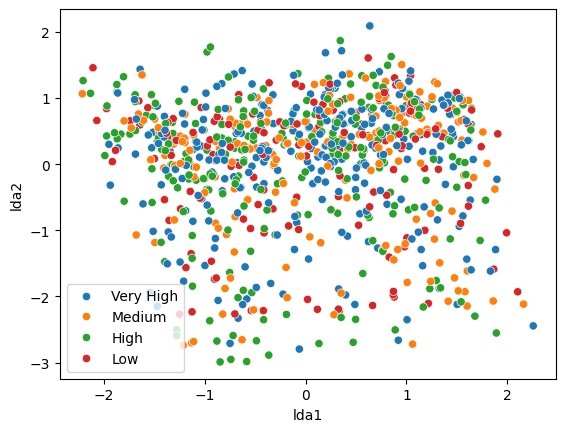

In [179]:
XNew = pd.DataFrame(lda().fit(X = X, y = y).transform(X), columns = ["lda1", "lda2", "lda3"])
XNew["JobSatisfaction"] = data["JobSatisfaction"]
sns.scatterplot(data = XNew,
                x = "lda1",
                y = "lda2",
                hue = data.JobSatisfaction.tolist())
plt.show()

In [180]:
XNew

,lda1,lda2,lda3,JobSatisfaction
0,-0.582012,-2.037498,-0.812739,Very High
1,1.315333,0.586428,-0.152667,Medium
2,1.370867,0.468851,1.523620,Medium
3,-0.820508,-2.267223,-0.721455,Medium
4,-0.704600,-0.371586,-1.357082,Medium
...,...,...,...,...
865,0.547417,0.249926,0.390133,Very High
866,0.723653,0.246370,-0.527862,Medium
867,-0.803903,0.060459,1.895779,Very High
868,-1.241799,0.010535,1.210686,High
